# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1624+0129

**Authors**: Ahmad Al - Imtiaz, S M Rafee Adnan, Sulyman Hossain, Anowar Shajib

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

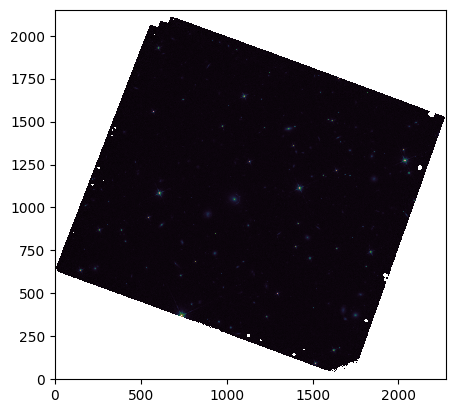

In [2]:
data, header = fits.getdata("DESIJ0618+5018_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

C:\Users\ahmad\AppData\Local\Temp\ipykernel_16688\3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


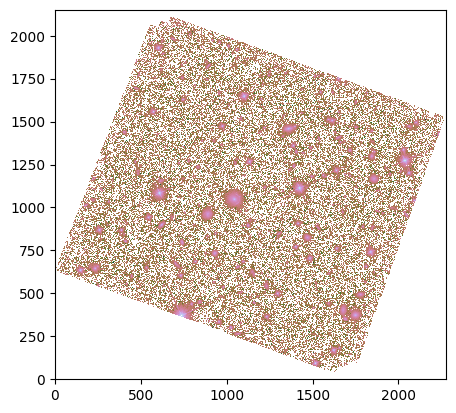

In [3]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

C:\Users\ahmad\AppData\Local\Temp\ipykernel_16688\2494072571.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


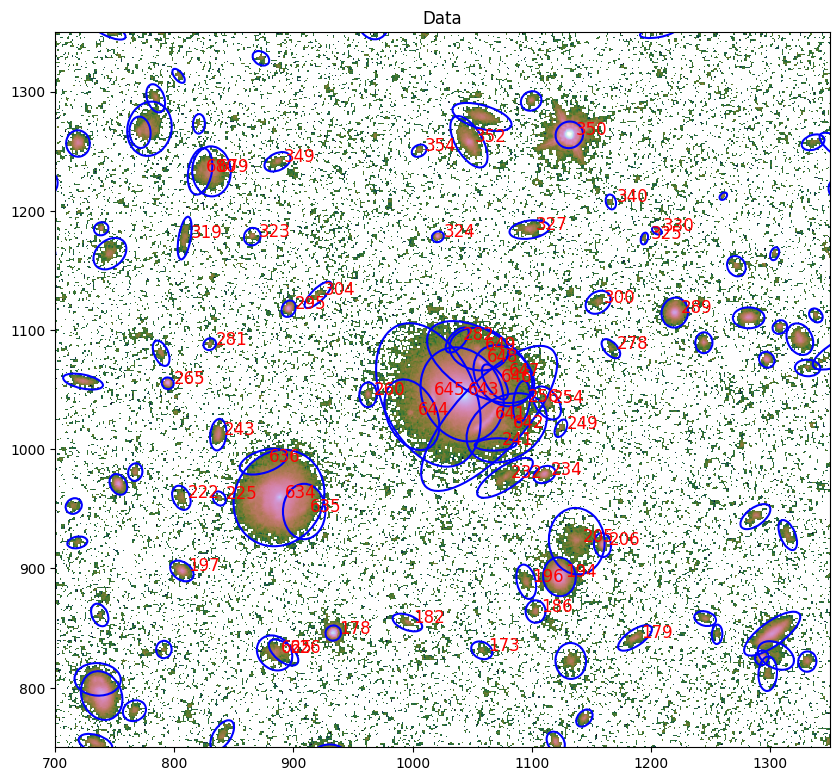

In [4]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 3 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=8,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[645]) < 220
        and np.abs(cat.ycentroid[i] - cat.ycentroid[645]) < 220
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 700, 1350
set_y_lim1, set_y_lim2 = 750, 1350

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

C:\Users\ahmad\AppData\Local\Temp\ipykernel_16688\260257024.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


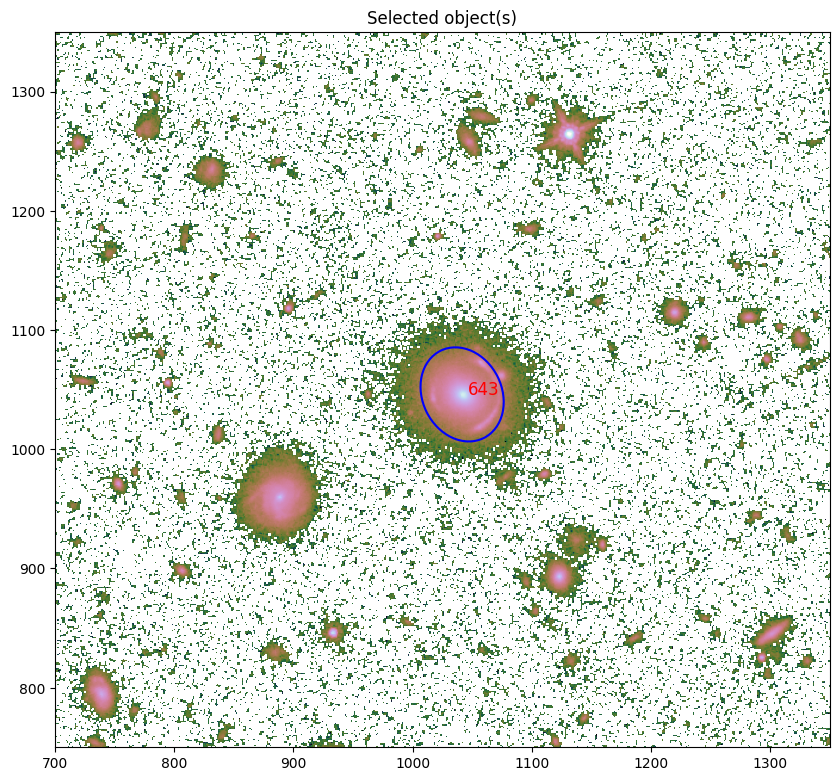

In [5]:
# Defining a function for labeling only selected objects
def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = [643]

# Calling the function label id_central
label_selected_objects(id_central)

In [6]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [7]:
# All close galaxies
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 51


In [8]:
# Close galaxies excluding sources lower than 1% of the central deflector
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 20


## Pixels to Arcsec unit

In [9]:
def distance_arcsec(pixel_distance):
    """Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in arcsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

## Identify the unwanted objects

C:\Users\ahmad\AppData\Local\Temp\ipykernel_16688\260257024.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


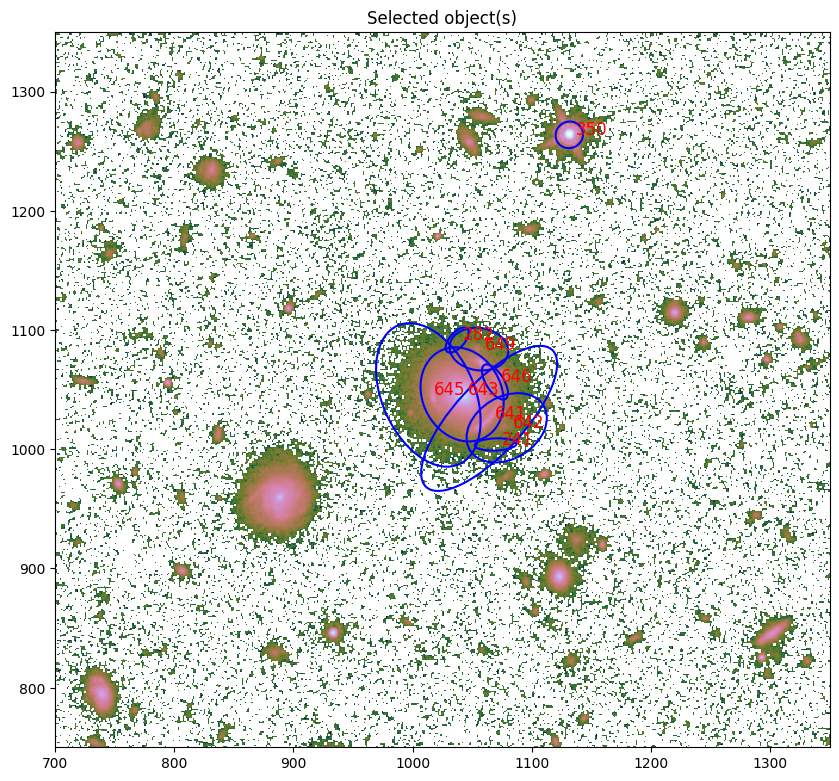

In [11]:
unwanted_object_ids = [241, 282, 350, 641, 642, 643, 645, 646, 649]
label_selected_objects(unwanted_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [33]:
# All close galaxies
remove_list = [
    300, #star
    780, # part of the arc
    782, # part of the arc
    783, # part of the arc
    784, # central deflector
    785, # part of the arc
    787, # part of the arc
    788, # part of the arc
    781 # part of the arc  
]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

         Distance(pixels)      Distance(arcsec)        Flux  Axis Ratio
789   [40.32004316832112]  [3.2256034534656575]   46.461823    0.531966
786   [40.40918705274264]   [3.232734964219379]   44.067658    0.983632
330   [62.24392369610285]   [4.979513895688178]  135.550639    0.816725
365    [62.4039921829287]   [4.992319374634246]   18.378569    0.847740
338   [64.90008339640903]  [5.1920066717126705]   11.542111    0.841493
404    [75.7834439651368]   [6.062675517210883]    1.782823    0.357990
401   [84.67745736747027]   [6.774196589397554]   32.432618    0.925928
368   [86.77180294243213]   [6.941744235394501]    2.204721    0.486271
329   [92.05405879993931]   [7.364324703995071]   86.568620    0.936359
793   [99.74541110600829]   [7.979632888480583]   64.110257    0.777195
319  [106.70964166728764]   [8.536771333382926]   32.610480    0.732076
355  [107.15916285005312]   [8.572733028004164]   47.421914    0.935328
792  [112.26753868056218]   [8.981403094444884]  378.351342    0

In [34]:
# Excluding galaxies lower than 1% of the central deflector
remove_list_1 = [
    300, #star
    780, # part of the arc
    782, # part of the arc
    783, # part of the arc
    784, # central deflector
    # 785, # part of the arc
    787, # part of the arc
    788, # part of the arc
    781 # part of the arc
]

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

         Distance(pixels)      Distance(arcsec)        Flux  Axis Ratioe
789   [40.32004316832112]  [3.2256034534656575]   46.461823     0.531966
786   [40.40918705274264]   [3.232734964219379]   44.067658     0.983632
330   [62.24392369610285]   [4.979513895688178]  135.550639     0.816725
365    [62.4039921829287]   [4.992319374634246]   18.378569     0.847740
338   [64.90008339640903]  [5.1920066717126705]   11.542111     0.841493
401   [84.67745736747027]   [6.774196589397554]   32.432618     0.925928
329   [92.05405879993931]   [7.364324703995071]   86.568620     0.936359
793   [99.74541110600829]   [7.979632888480583]   64.110257     0.777195
319  [106.70964166728764]   [8.536771333382926]   32.610480     0.732076
355  [107.15916285005312]   [8.572733028004164]   47.421914     0.935328
792  [112.26753868056218]   [8.981403094444884]  378.351342     0.610515
411  [119.77458386451404]   [9.581966709161026]   27.710273     0.823559
379  [119.80420976961159]   [9.584336781568831]    

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

In [35]:
# One faint object (along 9 o'clock) near the lens galaxy was undetected due to
# threshold conditions. To include this object in the calculation, we only take
# the distance of the 9th and 19th closest galaxies to calculate R_10 and R_20,
# which includes dim sources.
R_10_all = df_all_20.iloc[(9 - 1), df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[(19 - 1), df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)


# But we are not considering the previously described faint object in the list that
# excludes dim objects
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)


FOR All SOURCES
R 10: [7.3643247]
R 20: [10.48437677]
Sigma 10: [0.05869272]
Sigma 20: [0.05791551]

EXCLUDING DIM SOURCES
R 10: [8.57273303]
R 20: [12.1733779]
Sigma 10: [0.04331233]
Sigma 20: [0.04295937]


## Visualization

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13516\432903831.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13516\432903831.py:22: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13516\432903831.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13516\432903831.py:28: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


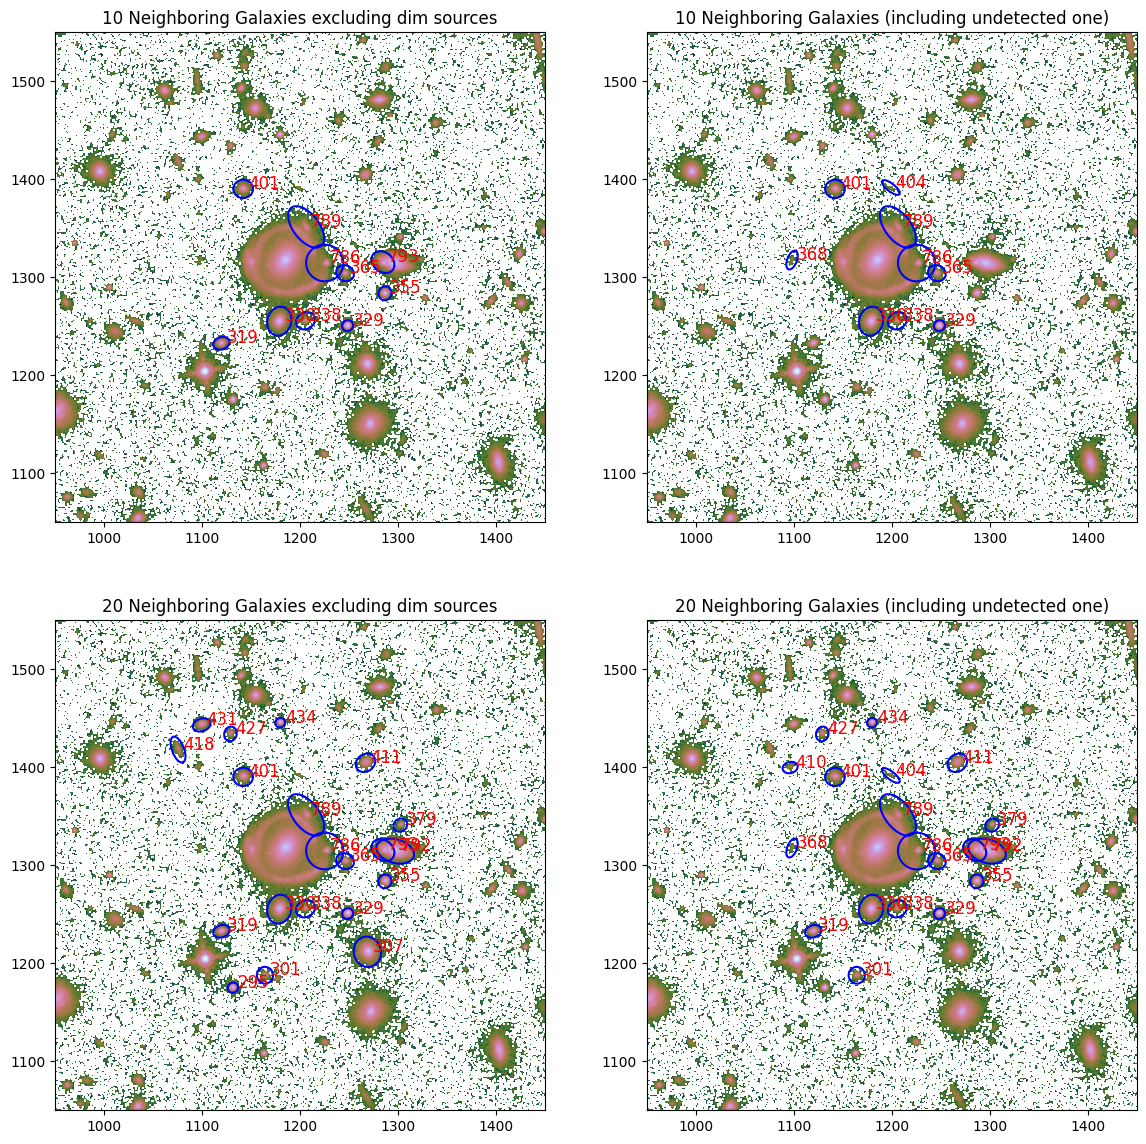

In [36]:
close_ids_all = list(df_all_20.index.values)
close_ids_all.pop(19)
close_ids_all_10 = close_ids_all[:10]
close_ids_all_10.pop(9)

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:9]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies (including undetected one)")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies (including undetected one)")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Store the results to the YAML file

In [37]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1624+0129_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [38]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.7911676353340044, 'Sigma_10': 0.058692724447482816, 'Sigma_10_flux_selected': 0.04331232817101363, 'Sigma_20': 0.05791550987501159, 'Sigma_20_flux_selected': 0.0429593710692385, 'center_x_light': [0.1685747140761507, 0.0007886162382499673, 0.0008196806608145035], 'center_x_mass': [0.1160039402793797, 0.004256724090001482, 0.004531564270525576], 'center_y_light': [0.0027536246367010396, 0.0007808365916191803, 0.0008534047131091719], 'center_y_mass': [0.14492518766850132, 0.003771500724678384, 0.003946915927265288], 'gamma': [1.7133957991624043, 0.04658807377724461, 0.0455235660612161], 'gamma_shear': [0.04090413852223468, 0.0032269756214787573, 0.0035814319561855504], 'phi_light': [-0.9841333153944359, 0.006245621205482554, 0.005475208759383121], 'phi_mass': [-0.8760129077486616, 0.0143913275902805, 0.013821069692916632], 'phi_shear': [-0.7473873446592517, 0.022101308144498732, 0.02344109181712517], 'q_light': [0.6978726192416134, 0.0024